In [9]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/ASD_Circuits/src')
from ASD_Circuits import *
from tabulate import tabulate

/home/jw3514/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
InfoMat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.csv", index_col=0)
adj_mat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/WeightMat.Ipsi.csv", index_col=0)

InfoMat_short = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.short.csv", index_col=0)

InfoMat_long = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.long.csv", index_col=0)

In [3]:
def normtoUnit(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)

def searchFil(text, DIR):
    RES = []
    for file in os.listdir(DIR):
        if text in file:
            RES.append(file)
    return RES

def LoadSA3(fname, DIR, InfoMat, topL=100):
    fin = open(DIR+fname, 'rt')
    max_score, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        bias = float(l[1])
        STRs = l[2].split(",")
        score = ScoreCircuit_SI_Joint(STRs, InfoMat)
        if score > max_score:
            max_score = score
            max_bias = bias
            max_STRs = STRs
    return max_score, max_bias, max_STRs

def GetData2(params, size, DIR, adj_mat, InfoMat):
    SCORES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in params.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        score, real_minbias, STRs = LoadSA3(fil, DIR, InfoMat)
        score = ScoreCircuit_SI_Joint(STRs, InfoMat)
        if score == 0:
            continue
        SCORES.append(score)
        CutBias.append(row["bias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
    return SCORES, CutBias, RealBias, STRS

def XXXX_cont(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat, InfoMat):
    #fil = searchFil("keepN_{}-minbias_{}.txt".format(size, bias), DIR)[0]
    SCORES, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat, InfoMat)
    New_RealBias = []
    for STRSET in STRS:
        xx = BiasDF.loc[STRSET, "EFFECT"].mean()
        New_RealBias.append(xx)
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_SI_Joint(topNSTRs, InfoMat)
    SCORES.append(score)
    CutBias.append(bias)
    New_RealBias.append(bias)
    STRS.append(topNSTRs)    
    return SCORES, CutBias, New_RealBias, STRS

def search_target_swap(size, BiasDF, NSwap, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        NDiff = len(set(STRs).difference(topNSTRs))
        if abs(NDiff-NSwap) < 2:

            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            if score > 0.714:
                #print(RegionDistributionsList(STRs))
                print(score, score1, score2)
            return bias, score, score1, score2
    return None, None, None, None

def search_target_swap2(size, BiasDF, biaslim, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        #print(round(real_minbias,3), biaslim)
        if round(real_minbias,3) == biaslim:
            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            if score2 > 0.673:
                #print()
                print(RegionDistributionsList(STRs))
            return bias, score, score1, score2
    return None, None, None, None

def LoadProfiles(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat, InfoMat):
    Scores, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat, InfoMat)
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF2.head(size)["EFFECT"].mean()
    score = ScoreCircuit_SI_Joint(topNSTRs, InfoMat)
    Scores.append(score)
    CutBias.append(bias)
    RealBias.append(bias)
    STRS.append(topNSTRs)    
    return Scores, CutBias, RealBias, STRS

In [4]:
size = 46
#biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
ASD_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/ASD_Pareto_SI_v2_Size46_Nov2023/"
ASD_BiasDF = pd.read_csv("../dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.csv", index_col="STR")
biaslim_df = pd.read_csv(
    "../dat/Circuits/SA/biaslims2/biaslim.size.46.top17.txt", names=["size", "bias"])
COHESPeak, CutBiasPeak, RealBiasPeak, STRSPeak = LoadProfiles(ASD_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                              ASD_DIR, adj_mat, InfoMat)
ASD_DFPeak = pd.DataFrame(data={"Cohe":COHESPeak, "minBias":CutBiasPeak, "Bias":RealBiasPeak})


In [9]:
size = 46
#biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
ASD_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/ASD_Pareto_Dec14_Info/"
ASD_BiasDF = pd.read_csv("../dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.csv", index_col="STR")
biaslim_df = pd.read_csv(
    "../dat/Circuits/SA/biaslims2/biaslim.size.46.top17.txt", names=["size", "bias"])
COHESPeak, CutBiasPeak, RealBiasPeak, STRSPeak = LoadProfiles(ASD_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                              ASD_DIR, adj_mat, InfoMat)
ASD_DFPeak_old = pd.DataFrame(data={"Cohe":COHESPeak, "minBias":CutBiasPeak, "Bias":RealBiasPeak})

In [5]:
print(RegionDistributionsList(STRSPeak[-3]))

Isocortex	19	Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Primary_motor_area; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Lateral_visual_area; Agranular_insular_area_posterior_part; Primary_somatosensory_area_trunk; Gustatory_areas; Agranular_insular_area_ventral_part; Orbital_area_medial_part; Anterior_cingulate_area_ventral_part
Olfactory_areas	3	Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area
Amygdala	3	Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Thalamus	7	Parafascicular_nucleus; Nucleus_of_reuniens; Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Parataenial_nucleus; Mediodorsal_nucleus_of_thalamus
Pallidum	1	Bed_nuclei_of_the_stria_terminalis
Str

In [6]:
print(RegionDistributionsList(STRSPeak[-4]))

Isocortex	19	Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Primary_motor_area; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Lateral_visual_area; Agranular_insular_area_posterior_part; Primary_somatosensory_area_trunk; Gustatory_areas; Agranular_insular_area_ventral_part; Orbital_area_medial_part; Anterior_cingulate_area_ventral_part
Olfactory_areas	3	Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area
Amygdala	3	Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Thalamus	8	Parafascicular_nucleus; Nucleus_of_reuniens; Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Parataenial_nucleus; Mediodorsal_nucleus_of_thalamus; Anteromedial_nucleus_dorsal_part
Pallidum	1	Bed_

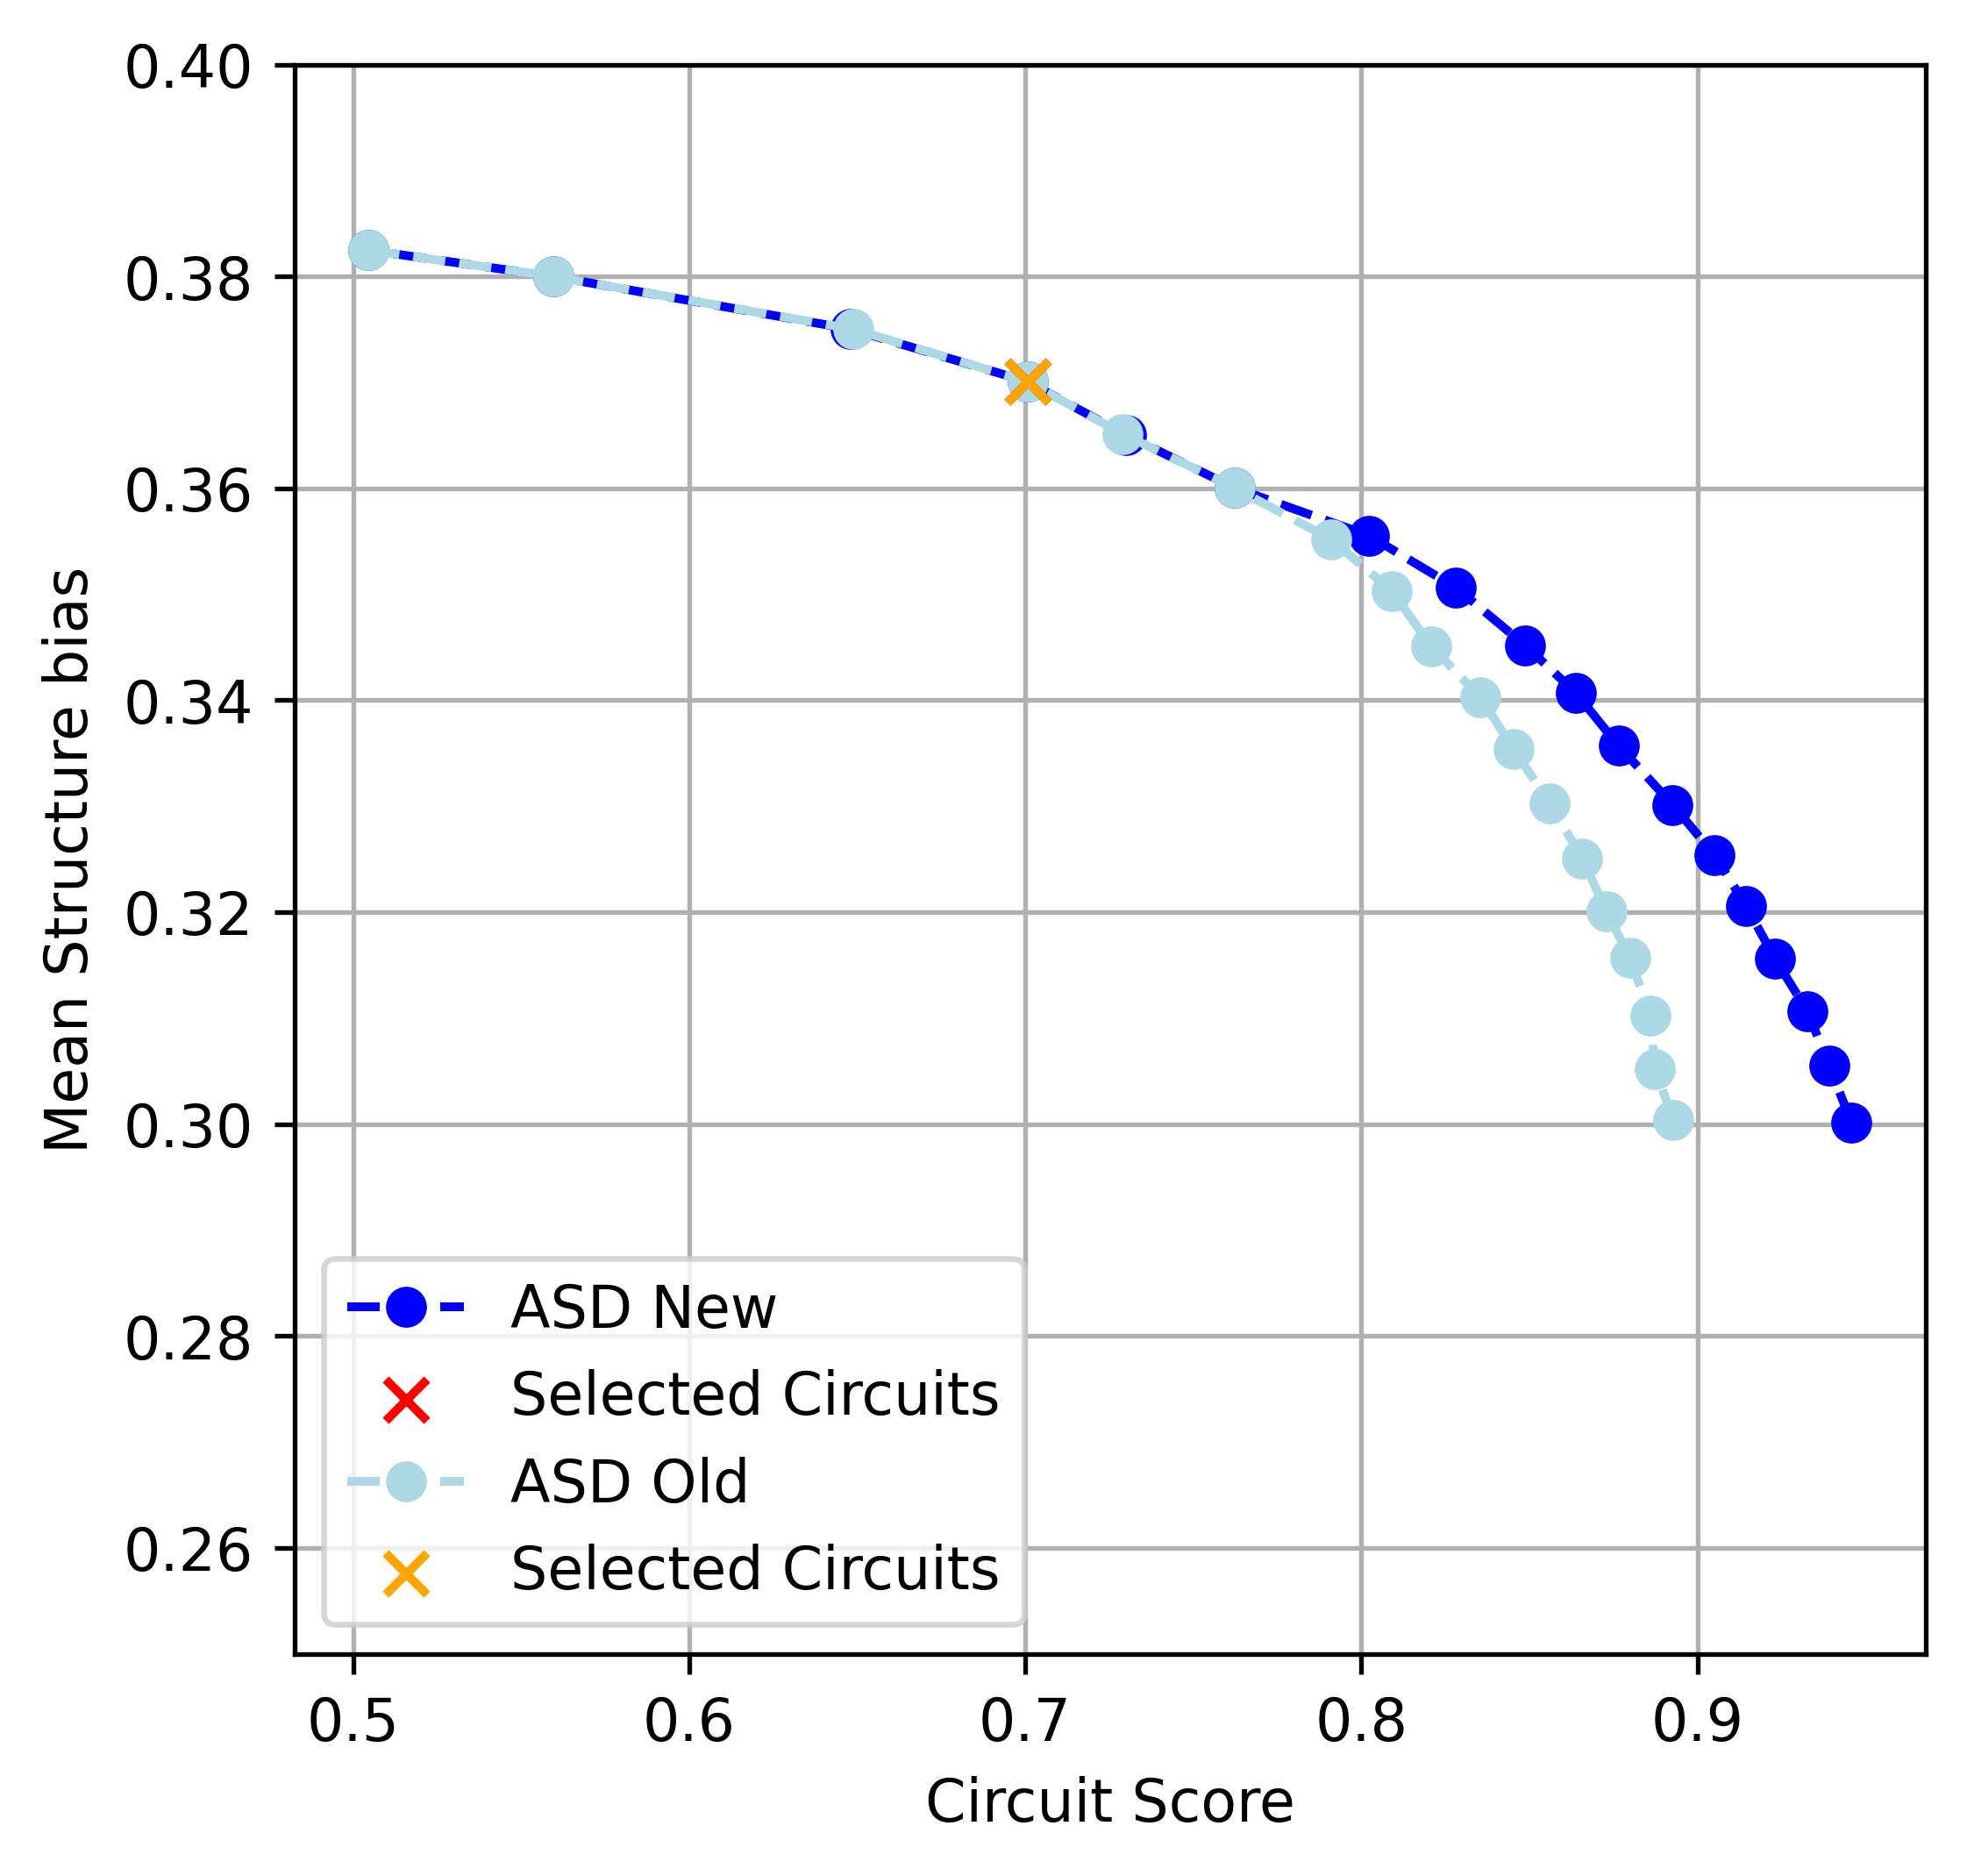

In [17]:
plt.figure(dpi=480, figsize=(5,5))
plt.plot(ASD_DFPeak["Cohe"].values, ASD_DFPeak["Bias"].values, marker="o", color="blue",
             ls = "--", label="ASD New")
plt.scatter(ASD_DFPeak["Cohe"].values[-4], ASD_DFPeak["Bias"].values[-4], marker="x", s=50, color="red",
           zorder=100, label="Selected Circuits")

plt.plot(ASD_DFPeak_old["Cohe"].values, ASD_DFPeak_old["Bias"].values, marker="o", color="lightblue",
             ls = "--", label="ASD Old")
plt.scatter(ASD_DFPeak_old["Cohe"].values[-4], ASD_DFPeak_old["Bias"].values[-4], marker="x", s=50, 
            color="orange", zorder=100, label="Selected Circuits")

plt.xlabel("Circuit Score")
plt.ylabel("Mean Structure bias")
plt.grid()
plt.ylim((0.25, 0.4))
plt.legend(loc="lower left")

In [1]:
40463+313436

353899

#### Test schduleing

In [6]:
import math
Tmin = 1e-5
Tmax = 1e-2
Steps = 100000
Tfactor = -math.log(Tmax/Tmin)
print(Tfactor)

-6.907755278982137


In [12]:
def Tfunc(step, Steps, Tfactor, Tmax):
    return Tmax * math.exp(Tfactor * step / Steps)

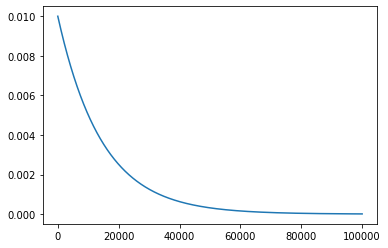

In [13]:
T1 = []
Times = range(0, Steps, 1)
for i in Times:
    T1.append(Tfunc(i, Steps, Tfactor, Tmax))
plt.plot(Times, T1)

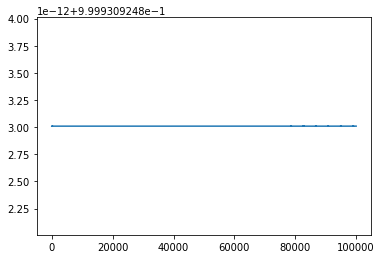

In [20]:
Times = range(0, Steps, 1)
Tfact = []
for i in Times[1:]:
    Tfact.append(T1[i]/T1[i-1])
plt.plot(Times[1:], Tfact)

In [ ]:
def Tfunc(step, Steps, Tfactor, Tmax):
    return Tmax * math.exp(Tfactor * step / Steps)

In [ ]:
T2 = []
Times = range(0, Steps, 1)
for i in Times:
    T1.append(Tfunc(i, Steps, Tfactor, Tmax))
plt.plot(Times, T1)